# Libraries

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import os
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import drive
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Mount Google Drive
drive.mount('/content/drive')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

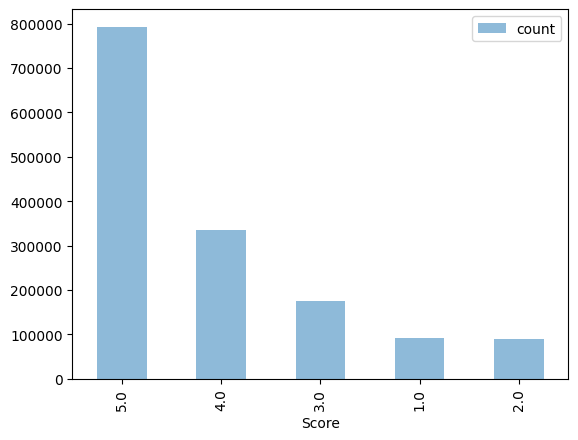


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [ ]:
trainingSet = pd.read_csv('/content/drive/MyDrive/train.csv')
testingSet = pd.read_csv('/content/drive/MyDrive/test.csv')


print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [ ]:
def add_features_to(df, max_text_length=250):
    # Initialize Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    # Check if 'HelpfulnessNumerator' and 'HelpfulnessDenominator' exist
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Calculate lengths of 'Summary' and 'Text' fields
    df['Summary_length'] = df['Summary'].str.len().fillna(0)
    df['Text_length'] = df['Text'].str.len().fillna(0)

    # Compute sentiment scores for 'Summary' text
    df['Summary_sentiment'] = df['Summary'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])
    df['Text_sentiment'] = df['Text'].fillna('').apply(lambda x: sia.polarity_scores(x[:max_text_length])['compound'])
    return df

X_train_path = "/content/drive/MyDrive/data/X_train.csv"
X_submission_path = "/content/drive/MyDrive/data/X_submission.csv"

train = add_features_to(trainingSet, 250)

# Merge on Id so that the submission set can have feature columns as well
X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
X_train =  train[train['Score'].notnull()]

os.makedirs('/content/drive/MyDrive/data', exist_ok=True)
X_train.to_csv(X_train_path, index=False)
X_submission.to_csv(X_submission_path, index=False)

# Sample + Split into training and testing set

In [ ]:
# Split training set into training and testing set
X = X_train.drop(columns=['Score'])
Y = X_train['Score']

X_train_split, X_test_split, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [ ]:
features = [
    'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness',
    'Summary_length', 'Text_length', 'Summary_sentiment', 'Text_sentiment'
]

X_train_select = X_train_split[features]
X_test_select = X_test_split[features]
X_submission_select = X_submission[features]

# Model Creation

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer for 'Summary'
vectorizer_summary = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform 'Summary' text
X_train_summary = vectorizer_summary.fit_transform(X_train_split['Summary'].fillna(''))
X_test_summary = vectorizer_summary.transform(X_test_split['Summary'].fillna(''))
X_submission_summary = vectorizer_summary.transform(X_submission['Summary'].fillna(''))

# Initialize TF-IDF Vectorizer for 'Text'
vectorizer_text = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform 'Text' field
X_train_text = vectorizer_text.fit_transform(X_train_split['Text'].fillna(''))
X_test_text = vectorizer_text.transform(X_test_split['Text'].fillna(''))
X_submission_text = vectorizer_text.transform(X_submission['Text'].fillna(''))

# Combine Numerical and Text Features
from scipy.sparse import hstack
from scipy import sparse

# Convert numerical features to sparse matrices
X_train_select_sparse = sparse.csr_matrix(X_train_select.values)
X_test_select_sparse = sparse.csr_matrix(X_test_select.values)
X_submission_select_sparse = sparse.csr_matrix(X_submission_select.values)

# Combine numerical and text features
X_train_combined = hstack([X_train_select_sparse, X_train_summary, X_train_text])
X_test_combined = hstack([X_test_select_sparse, X_test_summary, X_test_text])
X_submission_combined = hstack([X_submission_select_sparse, X_submission_summary, X_submission_text])

# Model Creation using LightGBM
import lightgbm as lgb

# Initialize and train the LightGBM model
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=0,
)
model.fit(X_train_combined, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_combined)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 39.421084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330017
[LightGBM] [Info] Number of data points in the train set: 1114005, number of used features: 2008
[LightGBM] [Info] Start training from score -2.792041
[LightGBM] [Info] Start training from score -2.806973
[LightGBM] [Info] Start training from score -2.133589
[LightGBM] [Info] Start training from score -1.488600
[LightGBM] [Info] Start training from score -0.626954


# Model Evaluation

LightGBM Accuracy on testing set = 0.6489998276493526


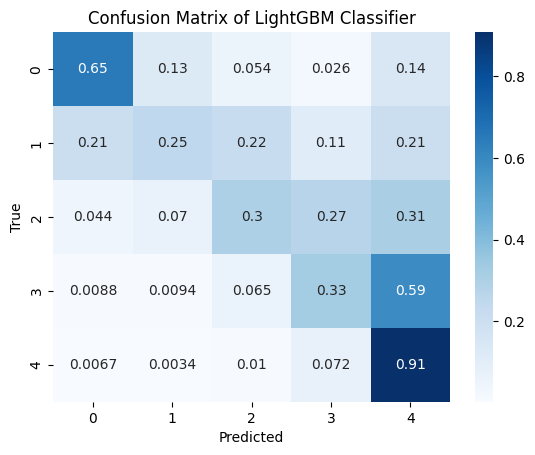

In [9]:
# Model Evaluation for LightGBM
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate your model on the testing set
print("LightGBM Accuracy on testing set =", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix of LightGBM Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [10]:
X_submission['Score'] = model.predict(X_submission_combined)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/drive/MyDrive/data/submission.csv", index=False)
print("Submission file created at /content/drive/MyDrive/data/submission.csv")

Submission file created at /content/drive/MyDrive/data/submission.csv
